# Imports

In [87]:
from pathlib import Path
import os
import pandas as pd
import torch as tc
import torchvision as tv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchsummary import summary as ts
import numpy as np
import torchvision.transforms as transforms
import sklearn.metrics as metrics
import seaborn as sns
from sklearn.metrics import classification_report

# Dataset and Dataloader

In [88]:
output_folder = Path(r"C:/Users/Michał/Documents/ISWD/workdir/beer_labels")

os.chdir(output_folder)

dirs = [d for d in os.listdir() if os.path.isdir(d)]

print(f"Output folder path: {output_folder}")

dataset_path = Path("C:/Users/Michał/Documents/ISWD/workdir/")
training_csv_path = os.path.join(dataset_path, "training.csv")
validation_csv_path = os.path.join(dataset_path, "validation.csv")
testing_csv_path = os.path.join(dataset_path, "testing.csv")

classes = []
for name in os.listdir(output_folder):
    dir_path = os.path.join(output_folder, name)
    if os.path.isdir(dir_path) and any(os.scandir(dir_path)):
        classes.append(name)

print("Liczba klas: " + str(len(classes)))
num_classes = len(classes)

Output folder path: C:\Users\Michał\Documents\ISWD\workdir\beer_labels
Liczba klas: 95


In [89]:
all_cases = []

for current_class in classes:
    class_path = os.path.join(output_folder, current_class)
    image_files = os.listdir(class_path)

    for i in range(len(image_files)):
        image_path = os.path.join(class_path, image_files[i])
        all_cases.append((image_path,  current_class))
      
train_cases, test_cases = train_test_split(all_cases, test_size=0.2, random_state=42)
train_cases, val_cases = train_test_split(train_cases, test_size=0.125, random_state=42)

train_df = pd.DataFrame(train_cases, columns=["image_path", "image_class_name"])
train_df.to_csv(training_csv_path)

val_df = pd.DataFrame(val_cases, columns=["image_path", "image_class_name"])
val_df.to_csv(validation_csv_path)

test_df = pd.DataFrame(test_cases, columns=["image_path", "image_class_name"])
test_df.to_csv(testing_csv_path)


In [108]:
class BeerDataset(tc.utils.data.Dataset):
    def __init__(self, dataset_path, csv_path, transforms=None, z_norm=False):
        self.dataset_path = dataset_path
        self.csv_path = csv_path
        self.dataframe = pd.read_csv(csv_path)
        self.transforms = transforms
        self.z_norm = z_norm

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.at[idx, 'image_path']
        current_class = self.dataframe.at[idx, 'image_class_name']

        current_image = tv.io.read_image(image_path)
        current_image = current_image.numpy()
        current_image = tc.from_numpy(current_image)
      

        if (len(current_image.shape) == 2):
          current_image = current_image.unsqueeze(2)
        #print(current_image.shape)
      
        if current_image.shape[2] == 1:
            current_image = current_image.repeat(1, 1, 3)
        if current_image.shape[2] == 4:
            current_image = current_image[:, :, :3]

        #current_image = current_image.permute(2, 0, 1)
        current_image = tv.transforms.functional.resize(current_image, (224,224), antialias=True)
        
        #print(current_image.shape)

        if self.transforms is not None:
          current_image = self.transforms(current_image)

        if self.z_norm:
          current_image = current_image.numpy()
          current_image = current_image.astype(np.float32)
          current_image = tc.from_numpy(current_image)
          current_image = tv.transforms.functional.normalize(current_image, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        else:
            current_image = current_image / 255.0
            current_image = (current_image - 0.5) / 0.5

        return current_image, current_class


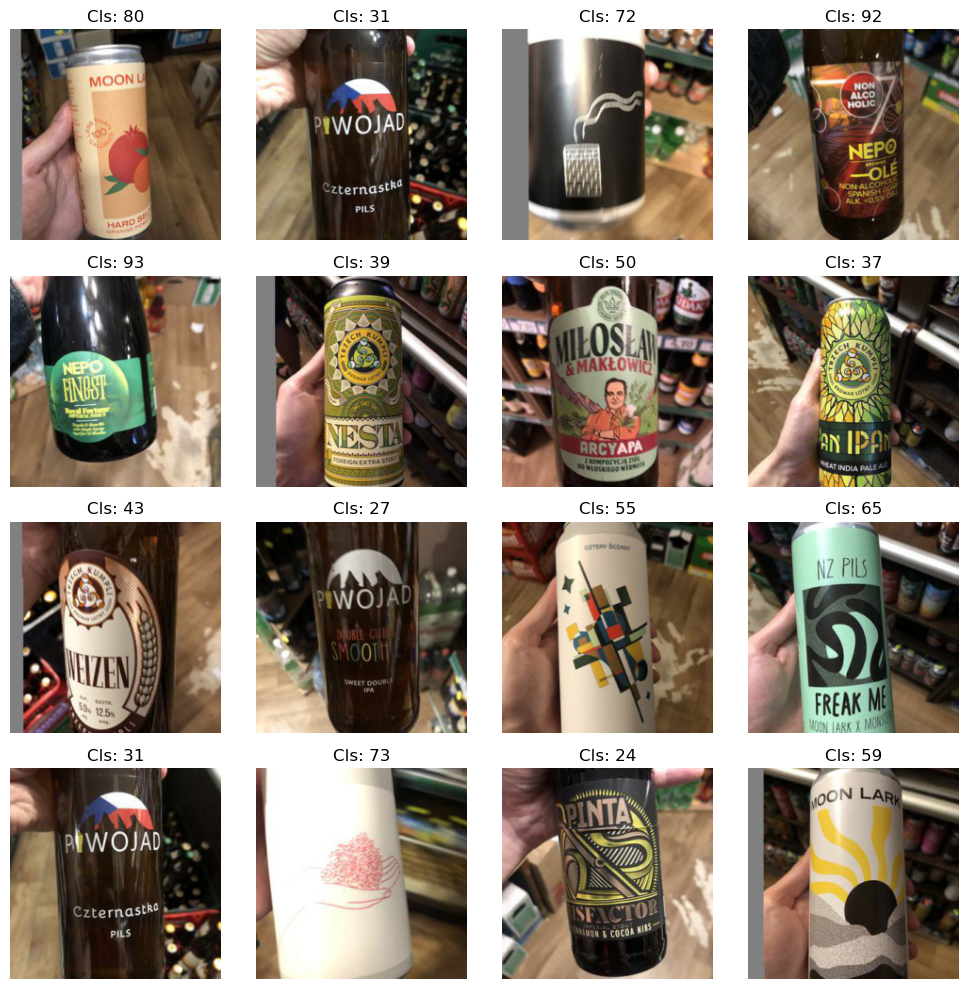

In [109]:
batch_size = 16
shuffle = True
# transforms = tc.nn.Sequential(
#   tv.transforms.AutoAugment(policy=tv.transforms.AutoAugmentPolicy.IMAGENET),
# )
dataset = BeerDataset(os.path.join(dataset_path, "tmp"), training_csv_path, z_norm=False)
dataloader = tc.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

for images, classes in dataloader:
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))

    for i, ax in enumerate(axes.flat):
        image = np.transpose(images[i].numpy(), (1, 2, 0))
        image = (image + 1) / 2
        ax.set_title("Cls: " + str(classes[i].item()))
        ax.imshow(image)
        ax.axis("off")

    plt.tight_layout()
    plt.show()
    break

# Neural Networks Architectures

In [92]:
class ClassificationNetwork(tc.nn.Module):
    def __init__(self):
        super(ClassificationNetwork, self).__init__()
        self.cnn = tc.nn.Sequential(
            tc.nn.Conv2d(3, 32, 3, 1, 1),
            tc.nn.BatchNorm2d(32),
            tc.nn.ReLU(),
            tc.nn.Conv2d(32, 64, 3, 2, 2),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 64, 3, 1, 1),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 64, 3, 2, 2),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 64, 3, 2, 2),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 64, 3, 2, 1),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.AdaptiveAvgPool2d((1,1))
        )
        self.nn = tc.nn.Sequential(
            tc.nn.Linear(64, 64),
            tc.nn.ReLU(),
            tc.nn.Linear(64, 64),
            tc.nn.ReLU(),
            tc.nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.nn(x)
        return x

In [93]:
device = "cuda:0" if tc.cuda.is_available() else "cpu"

classification_network = ClassificationNetwork()

batch_size = 4
random_input = tc.randn((batch_size, 3, 224, 224))
random_output = classification_network(random_input)

print(f"Size of the random input: {random_input.size()}")
print(f"Size of the random output: {random_output.size()}")
print("Random output: ")
print(random_output)

print("Network summary: ")
ts(classification_network.to(device), (3, 224, 224))

Size of the random input: torch.Size([4, 3, 224, 224])
Size of the random output: torch.Size([4, 95])
Random output: 
tensor([[-0.0362,  0.0460, -0.0985,  0.0110, -0.1110, -0.1048,  0.0554,  0.0809,
          0.1129, -0.0341,  0.0215, -0.0323,  0.0193,  0.0122,  0.0267,  0.0641,
          0.0080, -0.0048,  0.1173, -0.1993, -0.1125,  0.1330, -0.1038, -0.0287,
          0.0666, -0.1759,  0.1213, -0.0509,  0.0224,  0.1007, -0.0487,  0.0367,
          0.0543, -0.0576, -0.1022,  0.0176,  0.0338,  0.0972,  0.1516, -0.0185,
          0.0864,  0.0644, -0.0599,  0.0242,  0.0535, -0.0350,  0.0233, -0.0978,
          0.1883,  0.0078, -0.0165,  0.0457,  0.1293, -0.0294,  0.1080, -0.1330,
         -0.1367,  0.1089, -0.0446,  0.0324, -0.0282,  0.0202,  0.1294, -0.0011,
         -0.0185, -0.0448,  0.0664,  0.0325, -0.1170,  0.0234, -0.0229,  0.0179,
         -0.1763, -0.1004,  0.0220,  0.0576, -0.0585,  0.0490,  0.1053,  0.0542,
         -0.0667,  0.0837,  0.0036, -0.1193, -0.0189, -0.0383, -0.1608, 

In [94]:
class ImprovedClassificationNetwork(tc.nn.Module):
    def __init__(self):
        super(ImprovedClassificationNetwork, self).__init__()
        self.cnn = tc.nn.Sequential(
            tc.nn.Conv2d(3, 64, 3, 1, 1),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 64, 3, 1, 1),
            tc.nn.BatchNorm2d(64),
            tc.nn.ReLU(),
            tc.nn.Conv2d(64, 128, 3, 2, 1),
            tc.nn.BatchNorm2d(128),
            tc.nn.ReLU(),
            tc.nn.Conv2d(128, 128, 3, 1, 1),
            tc.nn.BatchNorm2d(128),
            tc.nn.ReLU(),
            tc.nn.Conv2d(128, 256, 3, 2, 1),
            tc.nn.BatchNorm2d(256),
            tc.nn.ReLU(),
            tc.nn.Conv2d(256, 256, 3, 1, 1),
            tc.nn.BatchNorm2d(256),
            tc.nn.ReLU(),
            tc.nn.Conv2d(256, 512, 3, 2, 1),
            tc.nn.BatchNorm2d(512),
            tc.nn.ReLU(),
            tc.nn.Conv2d(512, 512, 3, 1, 1),
            tc.nn.BatchNorm2d(512),
            tc.nn.ReLU(),
            tc.nn.AdaptiveAvgPool2d((1,1))
        )
        self.nn = tc.nn.Sequential(
            tc.nn.Linear(512, 512),
            tc.nn.BatchNorm1d(512),
            tc.nn.Dropout(0.5),
            tc.nn.ReLU(),
            tc.nn.Linear(512, 512),
            tc.nn.BatchNorm1d(512),
            tc.nn.Dropout(0.5),
            tc.nn.ReLU(),
            tc.nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.nn(x)
        return x

In [95]:
device = "cuda:0" if tc.cuda.is_available() else "cpu"
print("Device: " + device)

improved_classification_network = ImprovedClassificationNetwork()
batch_size = 4
random_input = tc.randn((batch_size, 3, 224, 224))
random_output = improved_classification_network(random_input)

print(f"Size of the random input: {random_input.size()}")
print(f"Size of the random output: {random_output.size()}")
print("Random output: ")
print(random_output)

print("Network summary: ")
ts(improved_classification_network.to(device), (3, 224, 224))

Device: cuda:0
Size of the random input: torch.Size([4, 3, 224, 224])
Size of the random output: torch.Size([4, 95])
Random output: 
tensor([[ 4.2496e-01,  1.9562e-01,  1.9769e-01,  3.5865e-01, -4.7921e-01,
         -3.4546e-01, -6.1336e-01, -5.2782e-01, -5.9451e-01, -6.2980e-01,
          2.4308e-01,  2.4252e-01, -8.5840e-01, -5.1634e-01, -7.7474e-01,
         -2.1759e-01, -3.6884e-01, -2.0258e+00,  4.9647e-01,  2.4547e-01,
          3.5021e-01,  1.4211e-01, -6.8156e-01, -1.3798e-01, -2.5511e-01,
         -4.3955e-01,  6.6819e-02, -4.9791e-01,  3.5252e-01,  3.5095e-01,
          2.9853e-01, -5.6211e-02,  5.4762e-01, -7.1829e-01,  5.4056e-02,
         -1.2375e-01,  4.5445e-01, -7.1066e-01,  3.3830e-01,  2.4569e-01,
         -8.6177e-01, -2.1744e-01, -1.0028e+00,  1.0733e+00, -7.3780e-01,
         -3.0944e-01,  5.0873e-01, -2.4579e-01, -1.0216e+00, -5.1203e-01,
         -4.6616e-01,  9.0239e-01, -1.9532e-01,  3.6181e-01, -1.7983e-01,
          6.4446e-01, -9.6406e-01, -2.6213e-01, -1.80

# Training

In [96]:
def training(model, training_dataloader, validation_dataloader, num_epochs, learning_rate):
  
  objective_function = tc.nn.CrossEntropyLoss() 
  parameters = model.parameters() 
  optimizer = tc.optim.Adam(parameters, learning_rate) 
  device = "cuda:0" if tc.cuda.is_available() else "cpu" 
  training_losses = []
  testing_losses = [] 
  model = model.to(device)
  
  print(f"Training dataset size: {len(training_dataloader.dataset)}")
  print(f"Testing dataset size: {len(validation_dataloader.dataset)}")
  for epoch in range(num_epochs):
    print(f"Current epoch: {epoch}")

    training_epoch_loss = 0.0
    model.train()
    for images, classes in training_dataloader:
        images, classes = images.to(device), classes.to(device) 
        output = model(images) 
        loss = objective_function(output, classes)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        training_epoch_loss += loss.item() * images.size(0)

    training_epoch_loss = training_epoch_loss / len(training_dataloader.dataset)
    training_losses.append(training_epoch_loss)
    print(f"Current epoch training loss: {training_epoch_loss}")

    testing_epoch_loss = 0.0
    model.eval()
    for images, classes in validation_dataloader:
      with tc.set_grad_enabled(False):
        images, classes = images.to(device), classes.to(device) 
        output = model(images) 
        loss = objective_function(output, classes)
        testing_epoch_loss += loss.item() * images.size(0)

    testing_epoch_loss = testing_epoch_loss / len(validation_dataloader.dataset)
    testing_losses.append(testing_epoch_loss)
    print(f"Current epoch validation loss: {testing_epoch_loss}")

  # Return the trained model and the history of training and testing losses
  return model, training_losses, testing_losses

In [97]:
learning_rate = 0.002
batch_size = 32
num_epochs = 50
shuffle = True
# transforms = tc.nn.Sequential(
#   tv.transforms.AutoAugment(policy=tv.transforms.AutoAugmentPolicy.IMAGENET),
# )

#Trainig dataset/dataloader
training_dataset = BeerDataset(os.path.join(dataset_path, "Training"), training_csv_path, z_norm=True)
training_dataloader = tc.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=shuffle)
# Validation dataset/dataloader
validation_dataset = BeerDataset(os.path.join(dataset_path, "Validation"), validation_csv_path, z_norm=True)
validation_dataloader = tc.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
# Testing dataset/dataloader
testing_dataset = BeerDataset(os.path.join(dataset_path, "Testing"), testing_csv_path, z_norm=True)
testing_dataloader = tc.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

In [98]:
classification_model, training_losses, testing_losses = training(classification_network, training_dataloader, validation_dataloader, num_epochs, learning_rate)

Training dataset size: 3430
Testing dataset size: 491
Current epoch: 0
Current epoch training loss: 3.904439845655124
Current epoch validation loss: 3.504429602574428
Current epoch: 1
Current epoch training loss: 2.768176471943758
Current epoch validation loss: 8.54002712894603
Current epoch: 2
Current epoch training loss: 2.347678089002826
Current epoch validation loss: 4.331498073220496
Current epoch: 3
Current epoch training loss: 2.130663090475099
Current epoch validation loss: 1.9525237894349574
Current epoch: 4
Current epoch training loss: 1.8263473726222537
Current epoch validation loss: 2.0159842025966603
Current epoch: 5
Current epoch training loss: 1.5369466557794689
Current epoch validation loss: 1.351956422848517
Current epoch: 6
Current epoch training loss: 1.2540895080427388
Current epoch validation loss: 1.01581582445234
Current epoch: 7
Current epoch training loss: 1.0091686676959601
Current epoch validation loss: 1.094262464226142
Current epoch: 8
Current epoch trainin

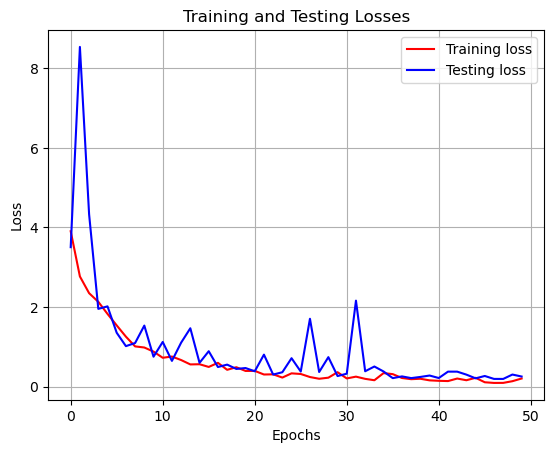

In [99]:
epochs = range(0, num_epochs)
plt.plot(epochs, training_losses, 'r', label='Training loss')
plt.plot(epochs, testing_losses, 'b', label='Testing loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')

plt.grid()
plt.legend()
plt.show()

In [101]:
new_dir = Path("C:/Users/Michał/Documents/ISWD/saved models")
os.chdir(new_dir)
tc.save(classification_model.state_dict(), "classification_model.pt")

current_dir = os.getcwd()
files = os.listdir(current_dir)
model_filename = 'classification_model.pt'
if model_filename in files:
    print(f'Saved model file {model_filename} found in {current_dir}.')
else:
    print(f'Saved model file {model_filename} not found in {current_dir}.')

Saved model file classification_model.pt found in C:\Users\Michał\Documents\ISWD\saved models.


In [102]:
improved_classification_model, training_losses, testing_losses = training(improved_classification_network, training_dataloader, validation_dataloader, num_epochs, learning_rate)

Training dataset size: 3430
Testing dataset size: 491
Current epoch: 0
Current epoch training loss: 3.581756209075972
Current epoch validation loss: 3.0649911381319437
Current epoch: 1


KeyboardInterrupt: 

In [ ]:
epochs = range(0, num_epochs)
plt.plot(epochs, training_losses, 'r', label='Training loss')
plt.plot(epochs, testing_losses, 'b', label='Testing loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')

plt.grid()
plt.legend()
plt.show()

In [ ]:
new_dir = Path("C:/Users/Michał/Documents/ISWD/saved models")
os.chdir(new_dir)
tc.save(improved_classification_model.state_dict(), "improved_classification_model.pt")

current_dir = os.getcwd()
files = os.listdir(current_dir)
model_filename = 'improved_classification_model.pt'
if model_filename in files:
    print(f'Saved model file {model_filename} found in {current_dir}.')
else:
    print(f'Saved model file {model_filename} not found in {current_dir}.')

# Evaluation

In [104]:
device = "cuda:0" if tc.cuda.is_available() else "cpu"
new_dir = Path("C:/Users/Michał/Documents/ISWD/saved models")
os.chdir(new_dir)

classification_model = ClassificationNetwork().to(device)
classification_model.load_state_dict(tc.load('classification_model.pt'))

improved_classification_model = ImprovedClassificationNetwork().to(device)
# improved_classification_model.load_state_dict(tc.load('improved_classification_model.pt'))

In [105]:
def accumulate_predictions(model, dataloader):
  predictions = []
  targets = []
  
  model.eval()
  with tc.set_grad_enabled(False):
      print(f"Dataset size: {len(dataloader.dataset)}")
      for images, classes in dataloader:
        images = images.to(device)
        classes = classes.to(device)

        output = model(images)
        pred = output.argmax(dim=1)

        predictions.append(pred.cpu())
        targets.append(classes.cpu())
  predictions = tc.cat(predictions)
  targets = tc.cat(targets)
  return predictions, targets

Dataset size: 3430
Dataset size: 981
Training Accuracy: 0.9717201166180758
Testing Accuracy: 0.9490316004077471
Training Report:
Testing Report:


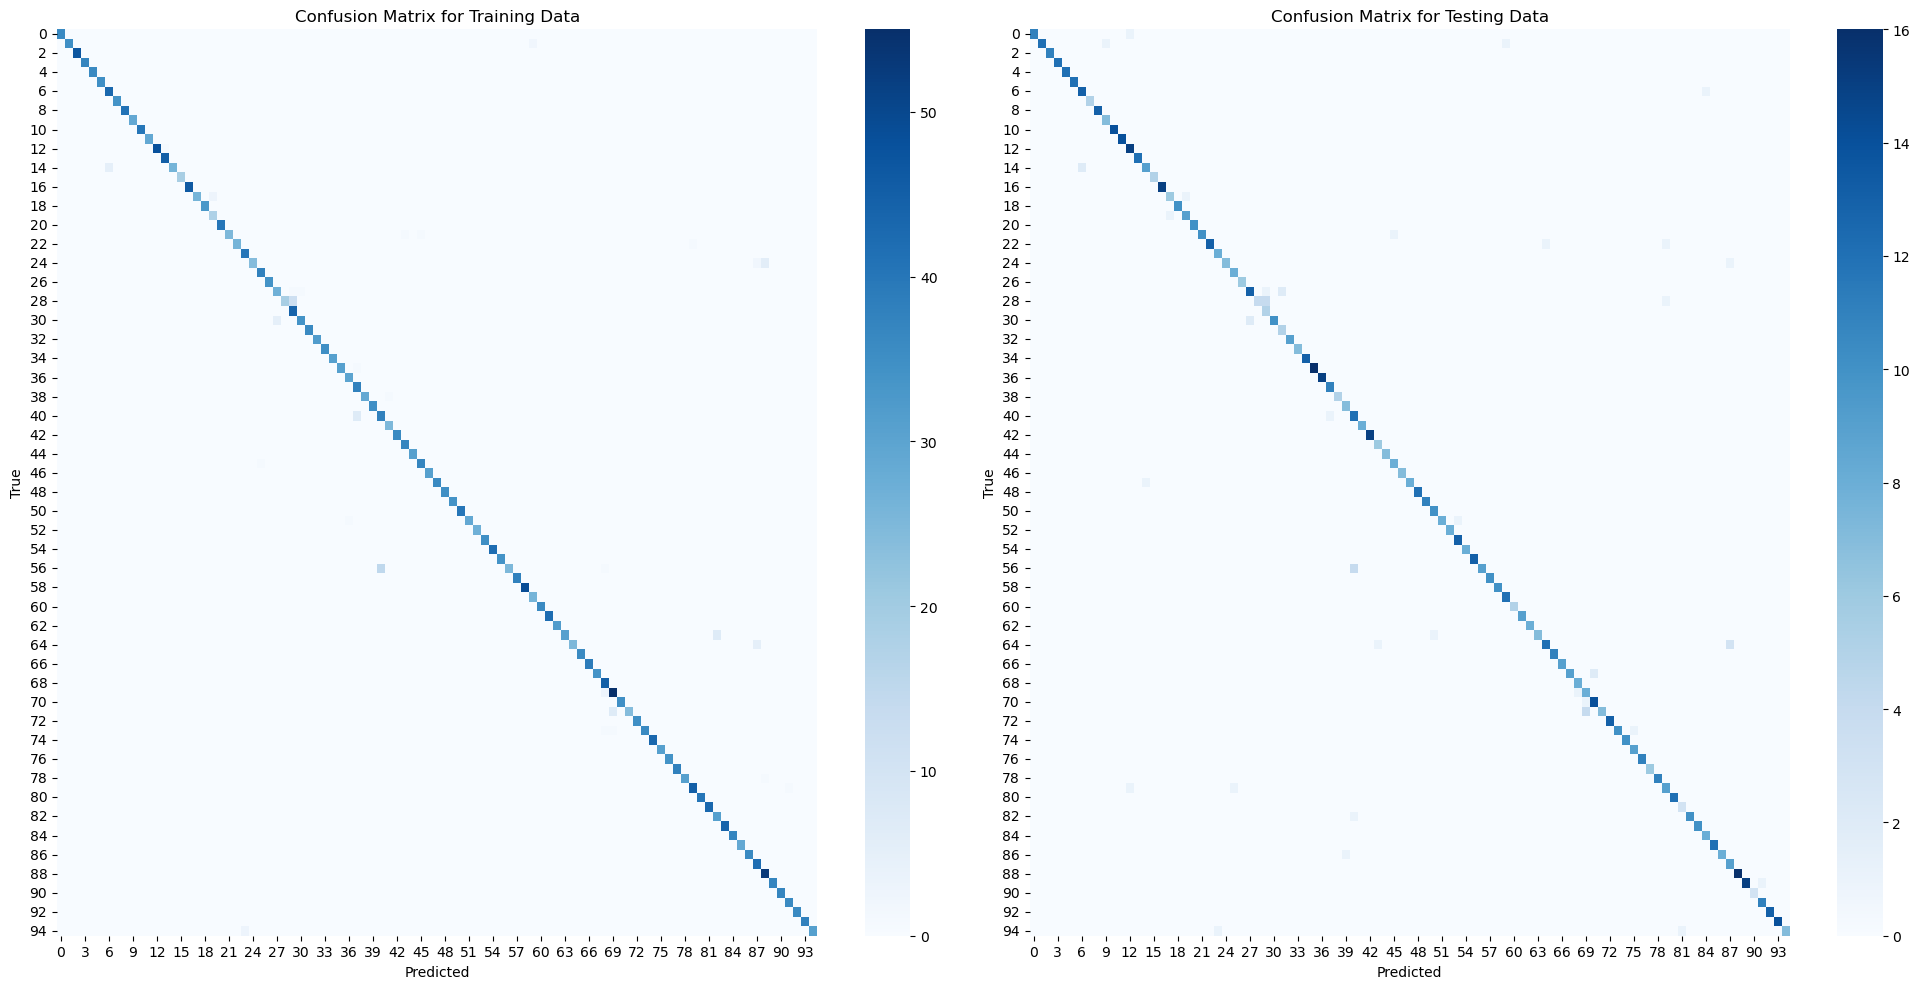

In [106]:
training_predictions, training_targets = accumulate_predictions(classification_model, training_dataloader)
testing_predictions, testing_targets =  accumulate_predictions(classification_model, testing_dataloader)

training_cm = metrics.confusion_matrix(training_targets, training_predictions)
testing_cm = metrics.confusion_matrix(testing_targets, testing_predictions)

# Calculate accuracy and sensitivity for training data
training_accuracy = metrics.accuracy_score(training_targets, training_predictions)
#training_report = classification_report(training_targets, training_predictions, target_names=classes)

# Calculate accuracy and sensitivity for testing data
testing_accuracy = metrics.accuracy_score(testing_targets, testing_predictions)
#testing_report = classification_report(testing_targets, testing_predictions, target_names=classes)

print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

print("Training Report:")
#print(training_report)
print("Testing Report:")
#print(testing_report)

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # Adjust the figsize as per your needs

# Plot the confusion matrix for training data
sns.heatmap(training_cm, cmap='Blues', ax=axs[0])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
axs[0].set_title('Confusion Matrix for Training Data')

# Plot the confusion matrix for testing data
sns.heatmap(testing_cm, cmap='Blues', ax=axs[1])
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')
axs[1].set_title('Confusion Matrix for Testing Data')

plt.tight_layout()  # Adjust the spacing between subplots

plt.show()

In [ ]:
training_predictions, training_targets = accumulate_predictions(improved_classification_model, training_dataloader)
testing_predictions, testing_targets =  accumulate_predictions(improved_classification_model, testing_dataloader)

training_cm = metrics.confusion_matrix(training_targets, training_predictions)
testing_cm = metrics.confusion_matrix(testing_targets, testing_predictions)

# Calculate accuracy and sensitivity for training data
training_accuracy = metrics.accuracy_score(training_targets, training_predictions)
#training_report = classification_report(training_targets, training_predictions, target_names=classes)

# Calculate accuracy and sensitivity for testing data
testing_accuracy = metrics.accuracy_score(testing_targets, testing_predictions)
#testing_report = classification_report(testing_targets, testing_predictions, target_names=classes)

print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

print("Training Report:")
#print(training_report)
print("Testing Report:")
#print(testing_report)

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # Adjust the figsize as per your needs

# Plot the confusion matrix for training data
sns.heatmap(training_cm, cmap='Blues', ax=axs[0])
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('True')
axs[0].set_title('Confusion Matrix for Training Data')

# Plot the confusion matrix for testing data
sns.heatmap(testing_cm, cmap='Blues', ax=axs[1])
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('True')
axs[1].set_title('Confusion Matrix for Testing Data')

plt.tight_layout()  # Adjust the spacing between subplots

plt.show()